In [2]:
import numpy as np
import pylab
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
rng = np.random.default_rng()
import os
os.chdir('C:/Users/chris/Downloads')


class RandomWalk:
    
    def __init__(self, type, portals):
        self.type = type
        self.portals = portals
        
        
    def normal_plot(self, mean, std, color="black"):
        """
        function used to plot the distribution of final positions of multiple walkers
        
        """
        a = np.linspace(mean-4*std, mean+4*std, 200)
        b = stats.norm.pdf(a, mean, std)
        c = plt.plot(a, b, color, linewidth=2)
    
    
    def single_plot(self, path, start, end):
        """
        function used to plot a single walker path
        
        """
        fig = plt.figure(figsize=(7,7),dpi=300)
        ax = fig.add_subplot()
        
        ax.plot(path[:,0], path[:,1], c='purple', alpha=0.5, lw=0.5)
        ax.scatter(path[:,0], path[:,1], c='black', alpha=0.5, s=0.7)
        ax.plot(start[:,0], start[:,1], c='red', marker='^')
        ax.plot(end[:,0], end[:,1], c='red', marker='H')
        ax.scatter(self.portals[:,0], self.portals[:,1], c='green', alpha=0.5, s=20, zorder=3)
        plt.gca().set_aspect('equal')
        plt.xlim(-5.5,5.5)
        plt.ylim(-3.5,4.5)
        plt.tight_layout()
        
        
    def simulation(self, origin, num_steps, group_size, choices, prob):
        """
        For use in the multi_walk and single_walk functions. Does the actual random walk simulation.
        The total number of steps to be taken by the walker is divided into groups of size group_size.
        A list of weighted steps are generated within each grouping, one after the other. The function then checks if
        any of the steps in the currently generated grouping will result in an overlap with a receptor. If
        there is an overlap, the walker is stopped with this as the final position of its path. If no overlap is found,
        the function adds these steps to the path and generates another grouping of steps to test. This continues until 
        the desired number of steps is reached, being num_steps.
        
        """
        path = origin
        for i in range(0, round(num_steps/group_size)):
            steps = rng.choice(choices, size=group_size, p=prob) #array of currently generated steps
            add_on = steps.cumsum(0) + path[-1, 0:2]
            check = np.concatenate([path, add_on]) #check if any step results in a receptor position
            for j in range(0, group_size):
                if (check[(j - group_size), 0:2].tolist() in self.portals.tolist()):
                    receptor = check[(j - group_size), 0:2] #receptor that walker intercepted with
                    add_on = (steps[0:j+1, 0:2]).cumsum(0) + path[-1, 0:2] #adds steps up to the receptor found
                    path = np.concatenate([path, add_on])
                    return(path, receptor)
                else:
                    continue 
            path = np.concatenate([path, add_on])
            
        receptor = None #receptor set to None if walker does not intercept any during simulation
        return(path, receptor)
        
        
    def multi_walk(self, dim=None, num_steps=None, num_sim=None, origin=None, choices=None, prob=None, group_size=None):
        """
        Args:
        
            dim: dimension of the random walk
            num_steps: number of steps for each walk
            num_sim: number of walks to be simulated
            origin: start position of walkers
            choices: step directions that can be taken
            prob: probability associated with each step direction
        
        Returns:
        
            Plots the distribution of final positions
            
        """
        
        if dim is None:
            dim = 2
        if num_steps is None:
            num_steps = 1000
        if num_sim is None:
            num_sim = 1000
        if origin is None:
            origin = np.zeros((1,dim))
        if choices is None:
            choices = [[1,0],[0,1],[-1,0],[0,-1]]
        if prob is None:
            prob = [1/4,1/4,1/4,1/4]
        if group_size is None:
            group_size = 10

        xfinal = np.zeros(num_sim) #lists to be populated with the final coordinate positions of each random walker
        yfinal = np.zeros(num_sim)
        receptor_list = None

        # Simulate steps in 2D
        for i in range (1,num_sim):
            path, receptor = self.simulation(origin, num_steps, group_size, choices, prob) #call simulation function
            end = path[-1:] #find end position of walk
            xfinal[i] = end[0][0]
            yfinal[i] = end[0][1]
            
            #this records the intercepted receptors. Could probably be improved.
            if receptor is None:
                continue
            else:
                if receptor_list is None:
                    receptor_list = receptor
                else:
                    if (receptor.tolist() in np.reshape(receptor_list, (int(len(receptor_list)/2),2)).tolist()):
                        continue
                    receptor_list = np.append(receptor_list, receptor, axis = 0)
        if receptor_list is not None:
            receptor_list = np.reshape(receptor_list, (int(len(receptor_list)/2),2))
            print('list of receptors intercepted: ', receptor_list.tolist())
        else:
            print('list of receptors intercepted: ', receptor_list)
        
        # plot the distribution of final position
        sns.histplot(xfinal, stat = 'density', color = 'red')
        self.normal_plot(xfinal.mean(), xfinal.std())
        pylab.show()

        sns.histplot(yfinal, stat = 'density', color = 'blue')
        self.normal_plot(yfinal.mean(), yfinal.std())
        pylab.show()
        
        
    def single_walk(self, dim=None, num_steps=None, origin=None, choices=None, prob=None, group_size=None):
        """
        Args:
        
            dim: dimension of the random walk. Currently not implemented, simulation is done in only 2D
            num_steps: number of steps for each walk
            origin: start position of walkers
            choices: step directions that can be taken
            prob: probability associated with each step direction
            group_size: the number of steps that are generated and tested at one time. Allows the function to check
                for receptor interception without generating the walker's full path.
        
        Returns:
        
            Plots and returns the path of the single walker, subject to receptor interception.
            
        """
        if dim is None:
            dim = 2
        if num_steps is None:
            num_steps = 1000
        if origin is None:
            origin = np.zeros((1,dim))
        if choices is None:
            choices = [[1,0],[0,1],[-1,0],[0,-1]]
        if prob is None:
            prob = [1/4,1/4,1/4,1/4]
        if group_size is None:
            group_size = 10
        
        random.seed()
        
        # simulate walk in 2D
        path, receptor = self.simulation(origin, num_steps, group_size, choices, prob) #call simulation function
        start = path[0:1] #defined for the purpose of plotting
        end = path[-1:]
        print('walker ran into receptor: ', receptor)

        # plot the path
        self.single_plot(path, start, end)
        
        return path

walker ran into receptor:  None


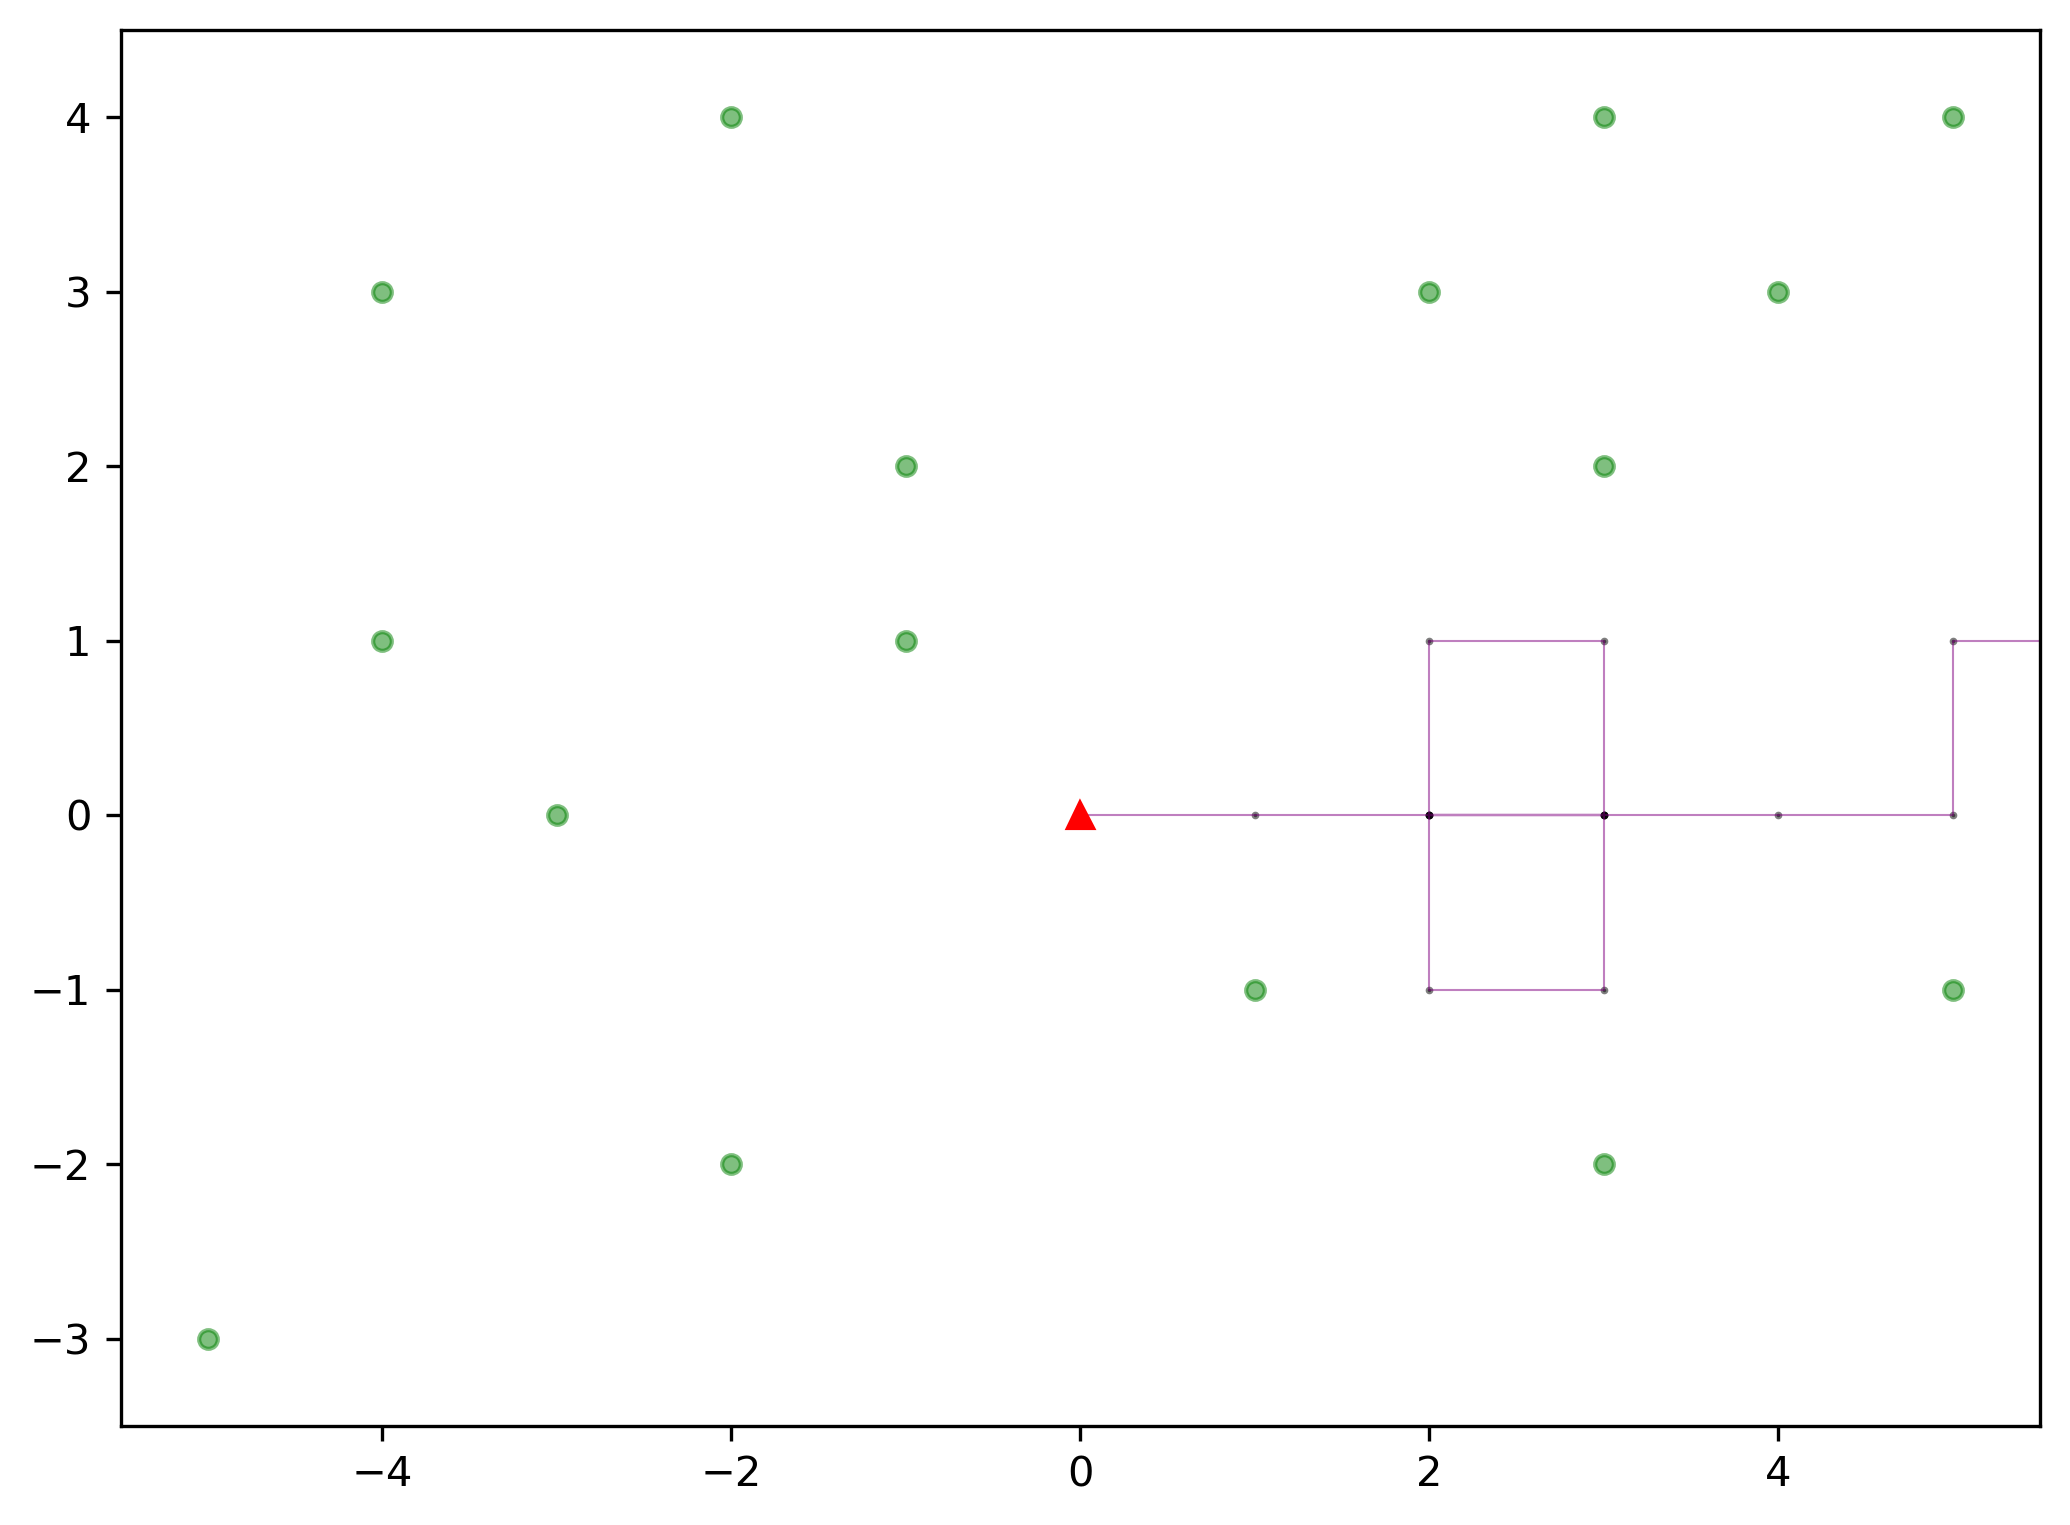

In [97]:
portals = np.array([[-1,2],[3,-2],[5,-1],[-2,4],[-2,-2],[1,-1],[-4,1],[-3,0],[-1,1],[-4,3],[3,4],[-5,-3],[5,4],[2,3],[3,2],[4,3]])
walker = RandomWalk('a',portals)
#portals = np.array([[1,2]])
array = walker.single_walk(num_steps=20,group_size=5, prob=[2/5,1/5,1/5,1/5])
plt.savefig('random.png',dpi=600,format="png")

list of receptors intercepted:  [[4.0, 4.0]]


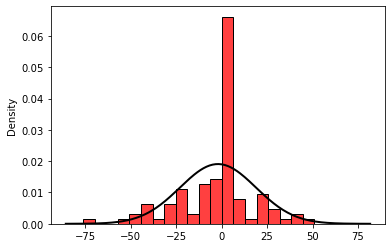

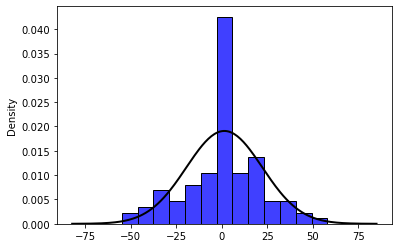

In [186]:
walker = RandomWalk('a')
portals = np.array([[4,4]])
#portals = np.array([[22,11],[15,10],[21,32],[1,6],[5,4],[2,30],[3,2],[20,3]])
walker.multi_walk(num_steps=1000,num_sim=100,group_size=10)

[   0.   23.  -64. ... -104.  -23.   26.] [  0. -89.  64. ... -72. 109.   6.]


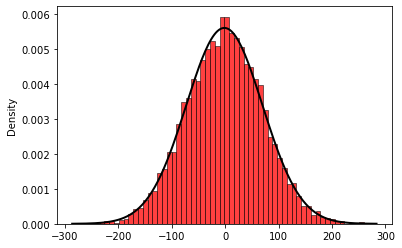

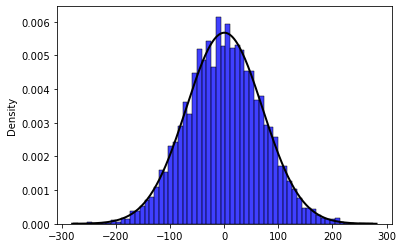

In [47]:
import numpy as np
import pylab
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
rng = np.random.default_rng()

# code for multiple simulations
# only cares for final positions

# function for calculating fit
def normal(mean, std, color="black"):
    a = np.linspace(mean-4*std, mean+4*std, 200)
    b = stats.norm.pdf(a, mean, std)
    c = plt.plot(a, b, color, linewidth=2)

# parameters for the walk
n = 10000 #number of steps per simulation
m = 10000 #number of simulations
origin = np.zeros((1,2))
choices = [[1,0],[0,1],[-1,0],[0,-1]] #step directions that can be taken
prob = [1/4,1/4,1/4,1/4] #probability of corresponding step direction

xfinal = np.zeros(m)
yfinal = np.zeros(m)

# Simulate steps in 2D
for i in range (1,m):
    random.seed()
    steps = rng.choice(choices, size=n, p=prob) #array of each step
    path = np.concatenate([origin, steps]).cumsum(0) #cumulative summation of steps
    start = path[0:1]
    end = path[-1:]
    
    xfinal[i] = end[0][0]
    yfinal[i] = end[0][1]
    
# plot the distribution of final position
sns.histplot(xfinal, stat = 'density', color = 'red')
normal(xfinal.mean(), xfinal.std())
pylab.show()

sns.histplot(yfinal, stat = 'density', color = 'blue')
normal(yfinal.mean(), yfinal.std())
pylab.show()

Text(219.9465339233038, 0.5, 'y')

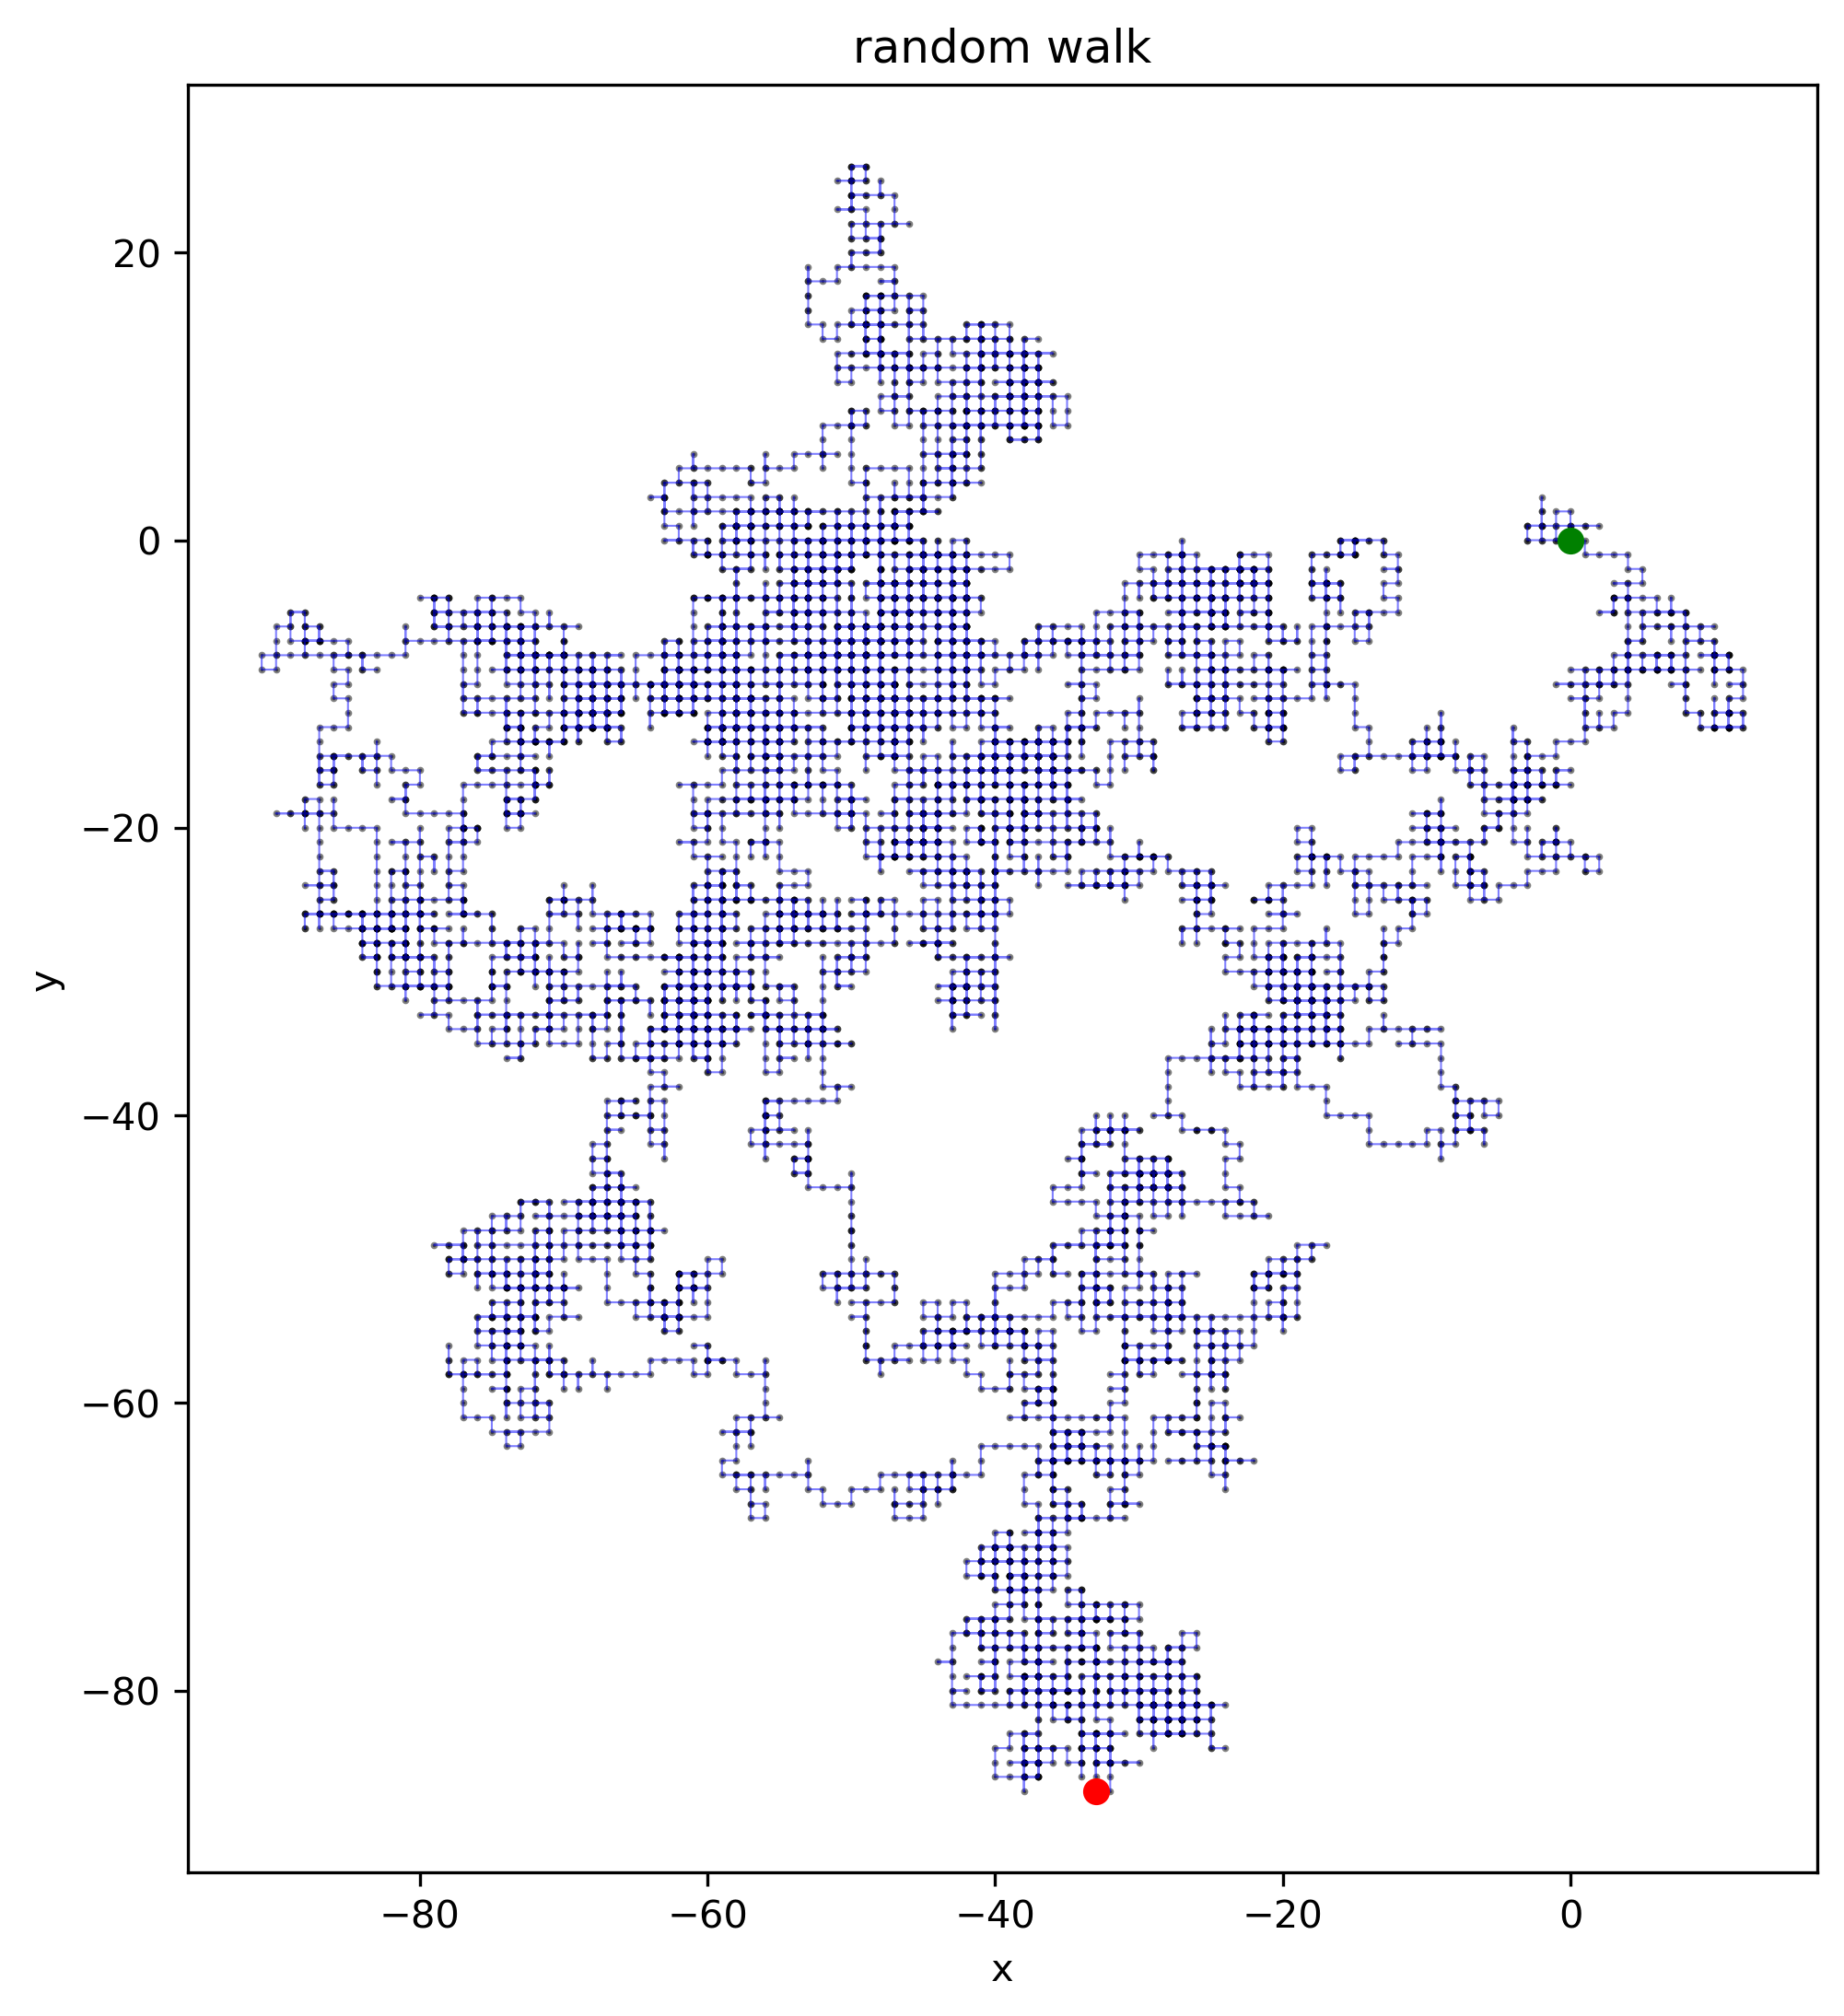

In [23]:
import numpy as np
import pylab
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
rng = np.random.default_rng()
random.seed()

# single walk code 
# keeps track of each position

# parameters for walk
n = 10000 #number of steps
origin = np.zeros((1,2))
choices = [[1,0],[0,1],[-1,0],[0,-1]] #step directions that can be taken
prob = [1/4,1/4,1/4,1/4] #probability of corresponding step direction

# simulate walk in 2D
steps = rng.choice(choices, size=n, p=prob) #array of each step
path = np.concatenate([origin, steps]).cumsum(0) #cumulative summation of steps
start = path[0:1]
end = path[-1:]

# plot the path
fig = plt.figure(figsize=(7,7),dpi=300)
ax = fig.add_subplot()
ax.scatter(path[:,0], path[:,1],c='black',alpha=0.5,s=0.7);
ax.plot(path[:,0], path[:,1],c='blue',alpha=0.5,lw=0.5);
ax.plot(start[:,0], start[:,1],c='green',marker='o')
ax.plot(end[:,0], end[:,1],c='red',marker='o')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.title('random walk')
plt.xlabel('x')
plt.ylabel('y')